# Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk

In [2]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
#Read the data
df = pd.read_csv("Reviews.csv")
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [3]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
df.shape

(500, 10)

# EDA

In [5]:
df['Score'].value_counts()

5    339
4     70
3     37
1     36
2     18
Name: Score, dtype: int64

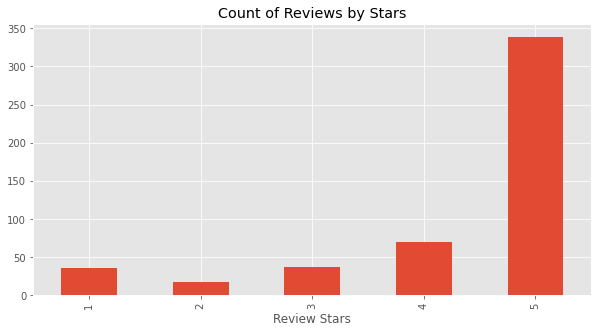

In [6]:
ax = df['Score'].value_counts().sort_index() \
.plot(kind='bar',title='Count of Reviews by Stars',
     figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

# Basic NLTK

In [7]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1.VADER Sentiment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approch:
1. Stop words are removed
2.each word is scored and combined to a total score

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores('I am so sad')

{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}

In [13]:
sia.polarity_scores('Today was the most happiest day of my life')

{'neg': 0.0, 'neu': 0.64, 'pos': 0.36, 'compound': 0.6697}

In [14]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [15]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [17]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


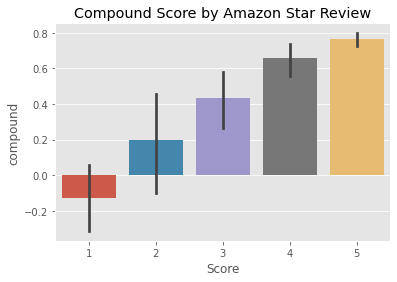

In [18]:
# plot VADER results
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

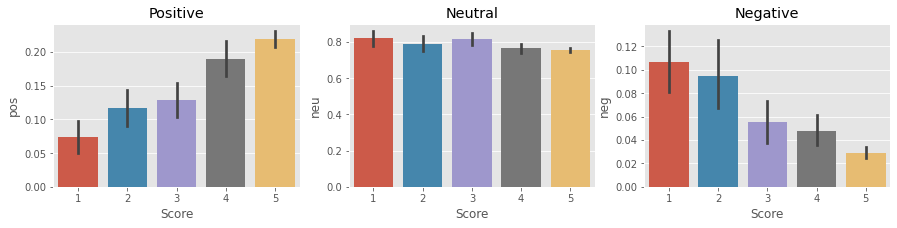

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

# Step 3. Roberta Pretrained Model

1.Use a model trained of a large corpus data.

2.Transformer model accounts for the words but also the context related to other words.

In [20]:
pip install transformers

In [21]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [22]:
MODEL =  f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [23]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [24]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2],
}
print(scores_dict)

{'roberta_neg': 0.9763551, 'roberta_neu': 0.020687474, 'roberta_pos': 0.0029573701}


In [25]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
    }
    return scores_dict

In [26]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [27]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [28]:
results_df.head(2)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# Compare Scores between models

In [29]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

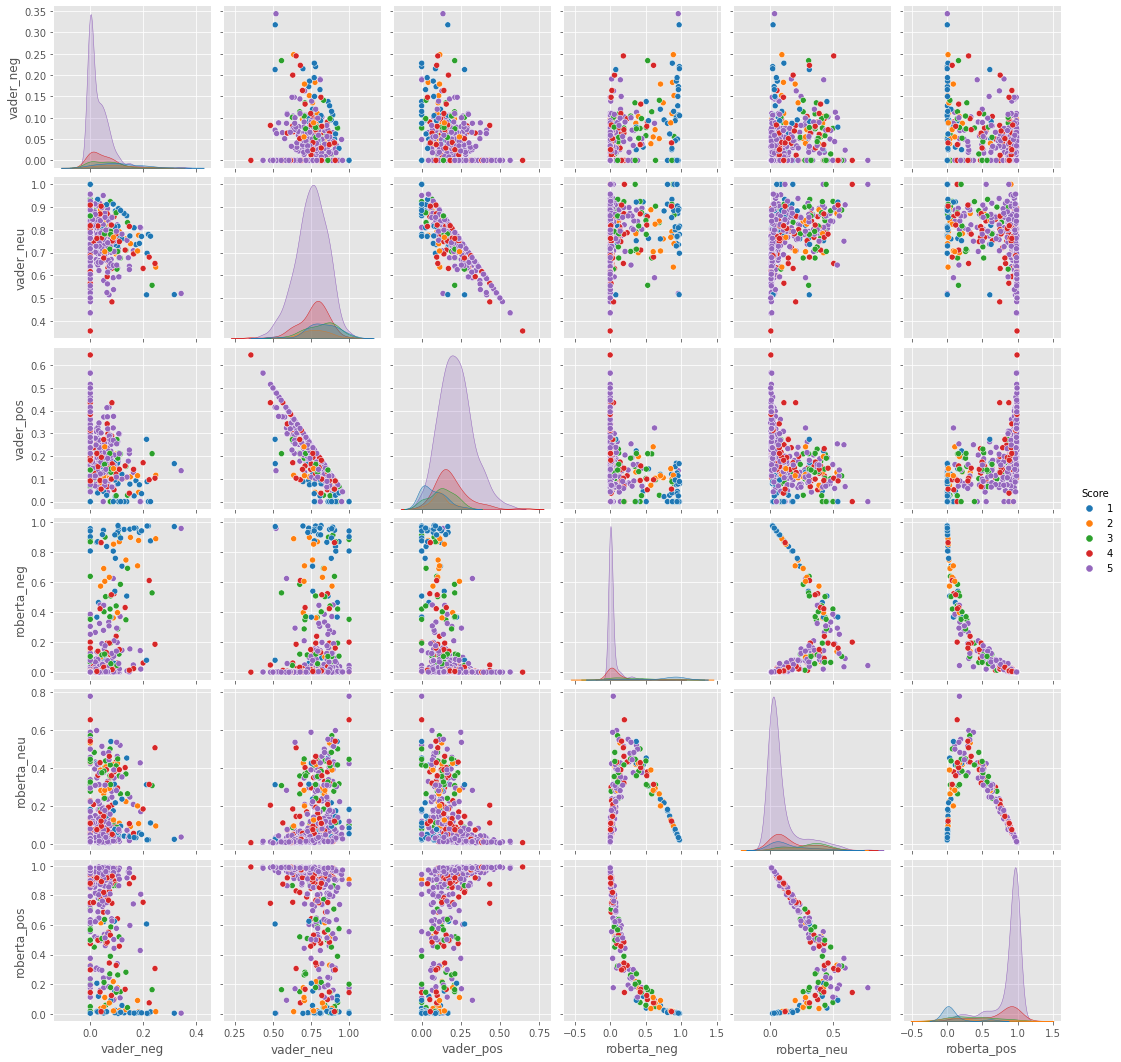

In [30]:
sns.pairplot(data=results_df,
            vars=['vader_neg','vader_neu','vader_pos',
                 'roberta_neg','roberta_neu','roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples

1.Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most

In [31]:
results_df.query('Score == 1').sort_values('roberta_pos',ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [32]:
results_df.query('Score == 1').sort_values('vader_pos',ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [34]:
# Negative sentiment  5 star review
results_df.query('Score == 5').sort_values('roberta_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [35]:
results_df.query('Score == 5').sort_values('vader_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'